<a href="https://colab.research.google.com/github/anupbagale/Heart_disease_prediction/blob/main/Heart_disaease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
!pip install ucimlrepo

In [3]:
# Importing the fetch_ucirepo function from ucimlrepo
from ucimlrepo import fetch_ucirepo

In [4]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# Display keys of the fetched dataset
heart_disease.keys()

dict_keys(['data', 'metadata', 'variables'])

In [5]:
# Assign features (X) and target (y) variables from the fetched dataset
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [6]:
# Display first few rows of the features X i.e. 5
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [7]:
# Check for null values in the features
# from table ca-->4 null value
# thal-->2 null value
null_values = X.isnull().sum()
print("Null values per feature:\n", null_values)


Null values per feature:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64


<Axes: >

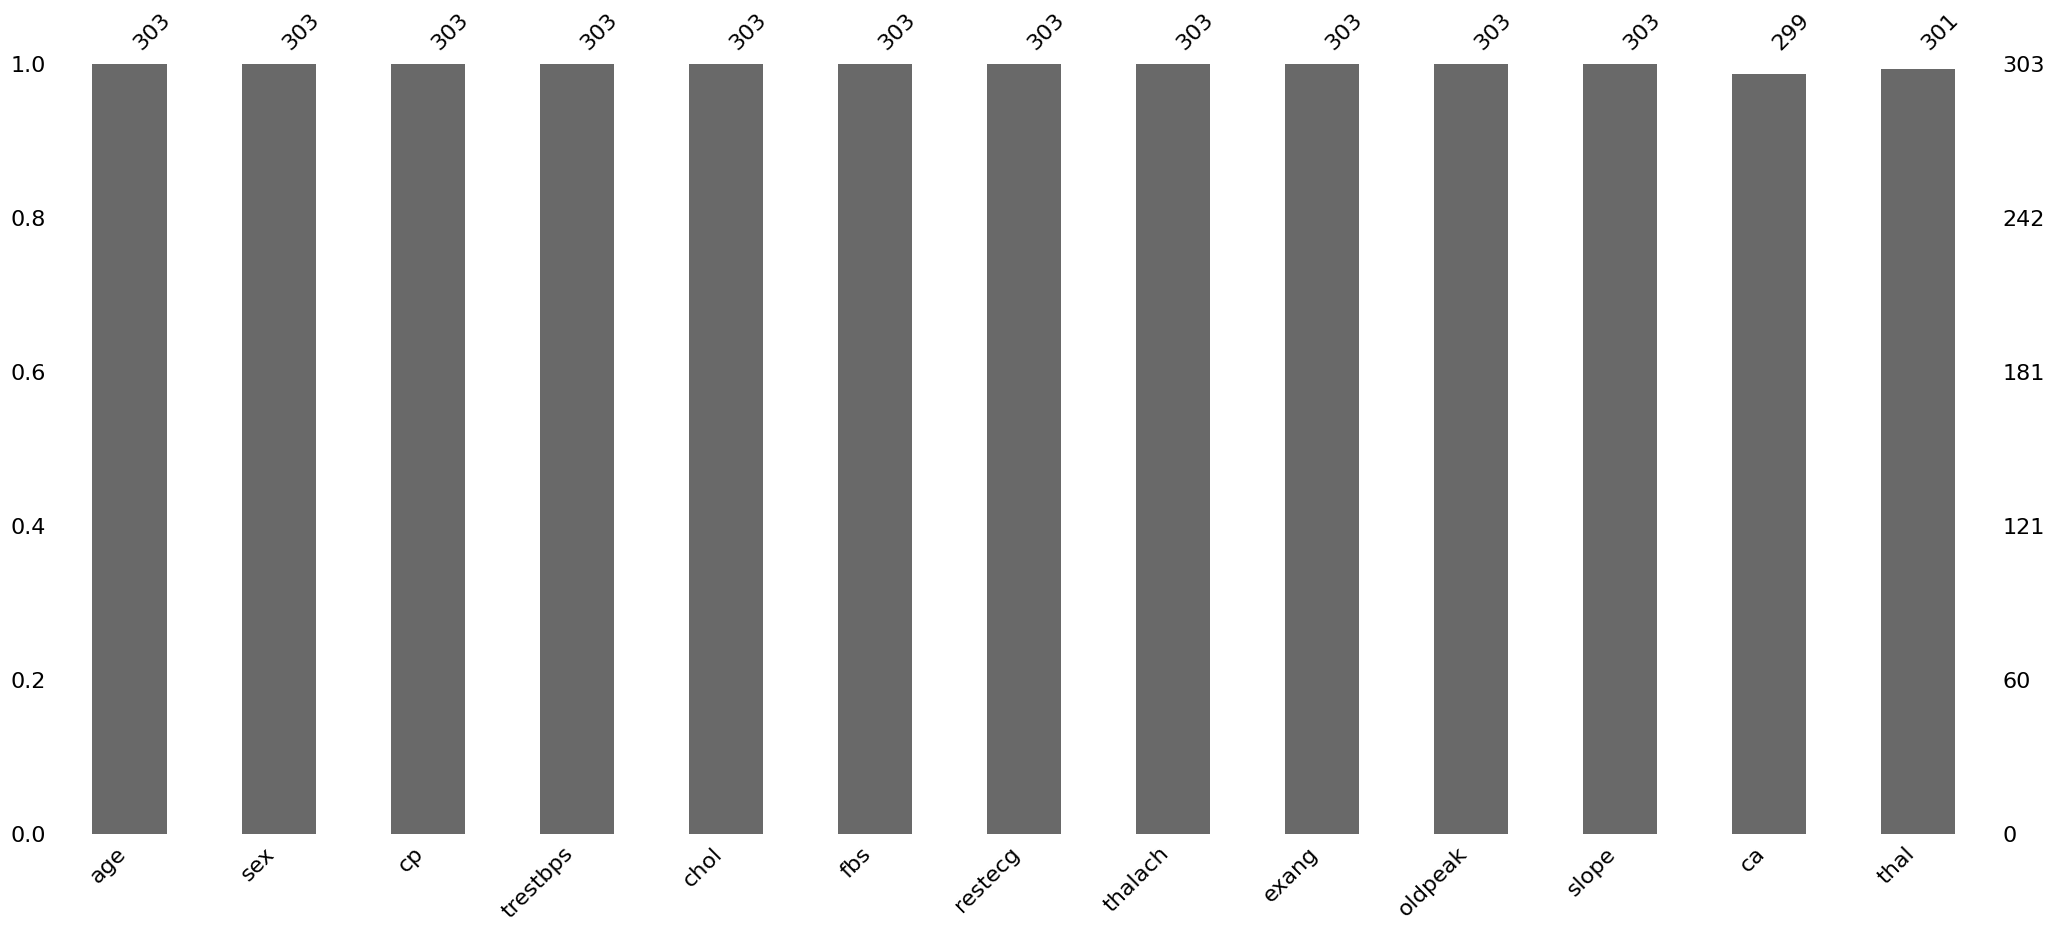

In [8]:
# Visualize missing values using missingno's bar chart
# missing value can be verified from chart as well
msno.bar(X)

In [9]:
# Impute missing values using mean imputation
# SimpleImputer is used to handle missing data in dataset.
# SimpleImputer(strategy='mean') --> fills in missing values in each column with the mean value of that column.

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Check if null values are removed after imputation
null_values_imputed = X_imputed.isnull().sum()
print("Null values per feature after imputation:\n", null_values_imputed)

# No, null number

Null values per feature after imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


<Axes: >

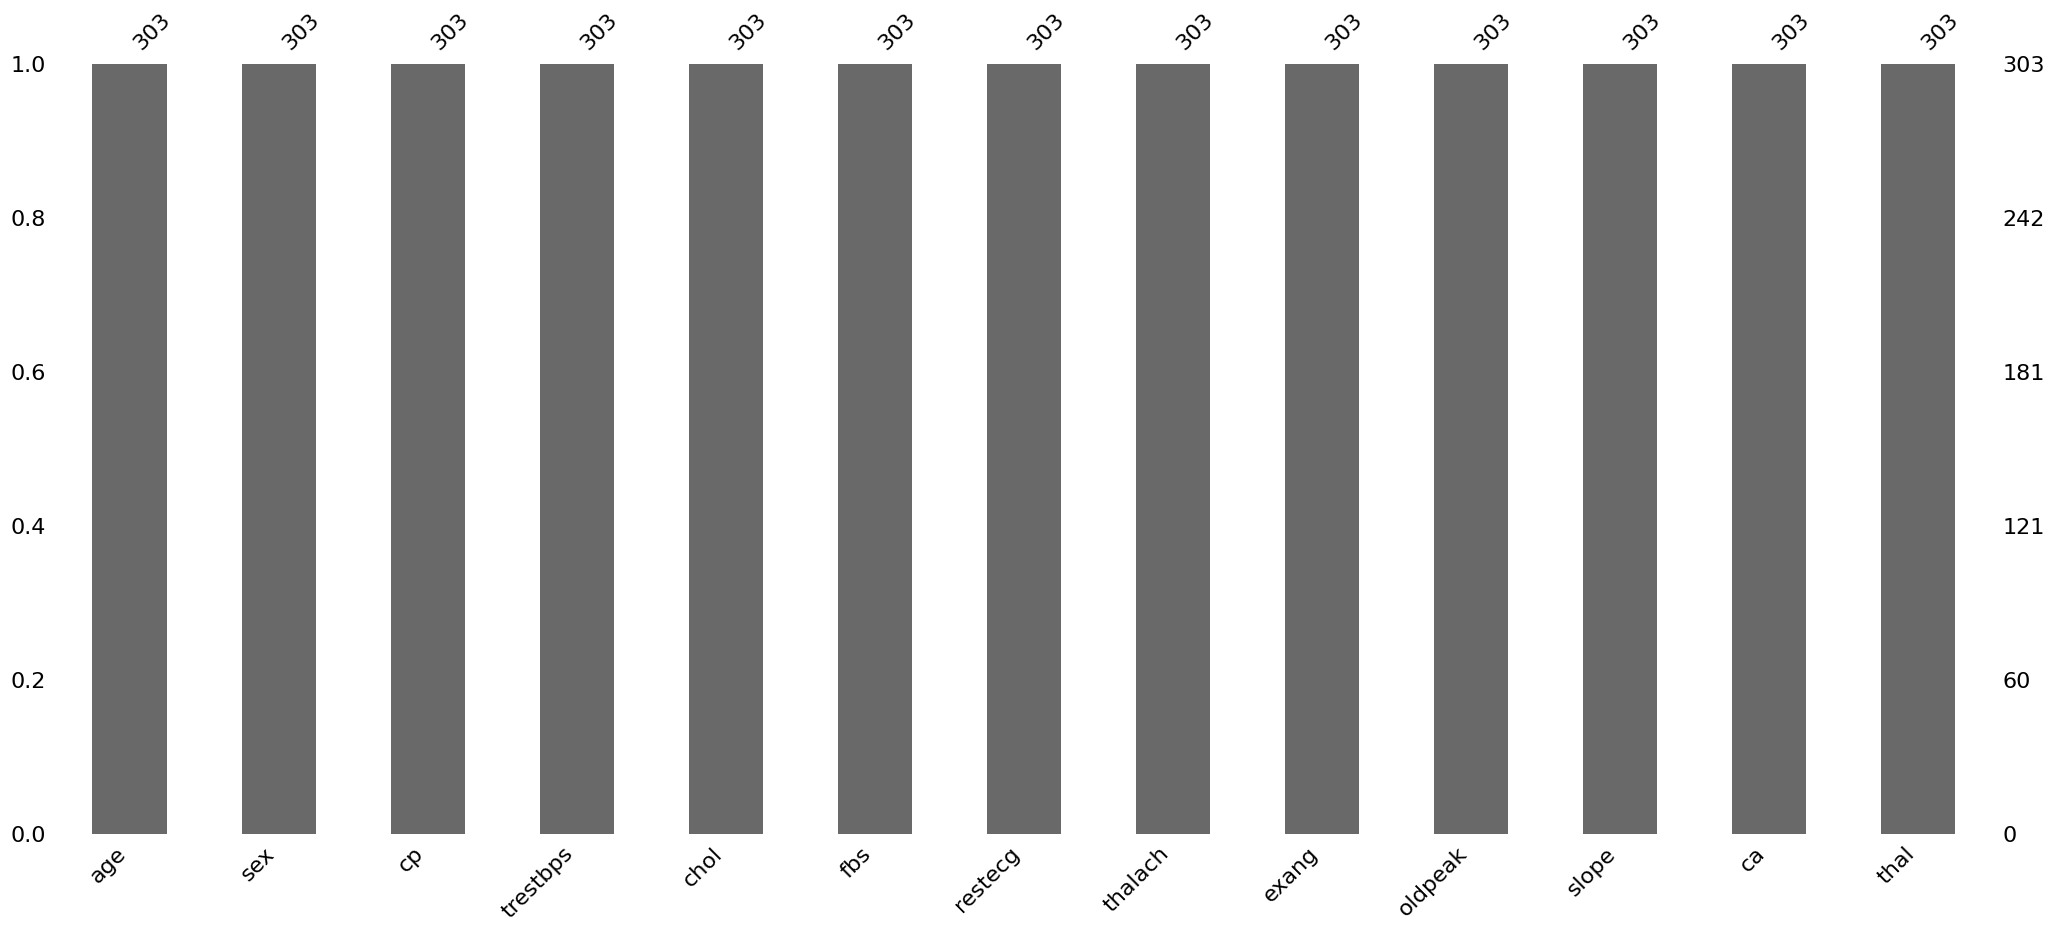

In [10]:
# Visualize missing values after imputation
msno.bar(X_imputed)

In [11]:
# Split the data into training and test sets
# test_size = 20% and train_size = 80%
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


In [12]:
# StandardScaler is used to standardize the features.
# Standaridize to have mean of 0 and a standard deviation of 1.

# Fit--> Compute the mean and standard deviation of each feature in the training data.
# Transform --> Apply the standardization transformation to the training and test data.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
# Sequential --> build a neural network layer by layer.
# model = Sequential --> initialize empty model
model = Sequential()

# model.add(dense(128.... --> first layer, 128 neurons, input_dim== X_train_scaled.shape[1] --> number of features in training data
# .shape[1] gives column --> 13, such as  age, sex, cp, trestbps, chol, fbs, restecg.................

model.add(Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(BatchNormalization())  # normalizing the output of the previous layer i.e 1st layer
model.add(Dense(64, activation='relu')) #second layer
model.add(Dropout(0.3))  # randomly turns off 30% of its neurons during training to prevent overfitting --> generally between 0.25-0.5
model.add(Dense(32, activation='relu'))# third layer
model.add(Dense(1, activation='sigmoid')) #final layer. 1 neurons --> binary classification (output is either 0 or 1).
# sigmoid activation function ensures the output is a probability between 0 and 1.

# Compile the model with adjusted hyperparameters

# optimizer--> helps the model learn by adjusting the weights

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Train the model

# epochs=50: Train the model for 50 rounds.
# batch_size=32: Process 32 samples at a time.
# validation_split=0.2: Use 20% of the training data to validate the model during training.
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/50
4/4 [==============================] - 3s 194ms/step - loss: 0.7407 - accuracy: 0.4819 - val_loss: 0.5634 - val_accuracy: 0.4286
Epoch 2/50
4/4 [==============================] - 0s 26ms/step - loss: 0.1844 - accuracy: 0.4870 - val_loss: 0.3874 - val_accuracy: 0.4286
Epoch 3/50
4/4 [==============================] - 0s 24ms/step - loss: -0.2559 - accuracy: 0.4974 - val_loss: 0.2292 - val_accuracy: 0.4082
Epoch 4/50
4/4 [==============================] - 0s 26ms/step - loss: -0.5047 - accuracy: 0.4922 - val_loss: 0.0600 - val_accuracy: 0.4082
Epoch 5/50
4/4 [==============================] - 0s 23ms/step - loss: -0.8058 - accuracy: 0.4974 - val_loss: -0.1244 - val_accuracy: 0.4286
Epoch 6/50
4/4 [==============================] - 0s 34ms/step - loss: -1.2993 - accuracy: 0.4922 - val_loss: -0.3297 - val_accuracy: 0.4490
Epoch 7/50
4/4 [==============================] - 0s 33ms/step - loss: -1.8148 - accuracy: 0.5285 - val_loss: -0.5635 - val_accuracy: 0.4286
Epoch 8/50
4/4 [==

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1792      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                        

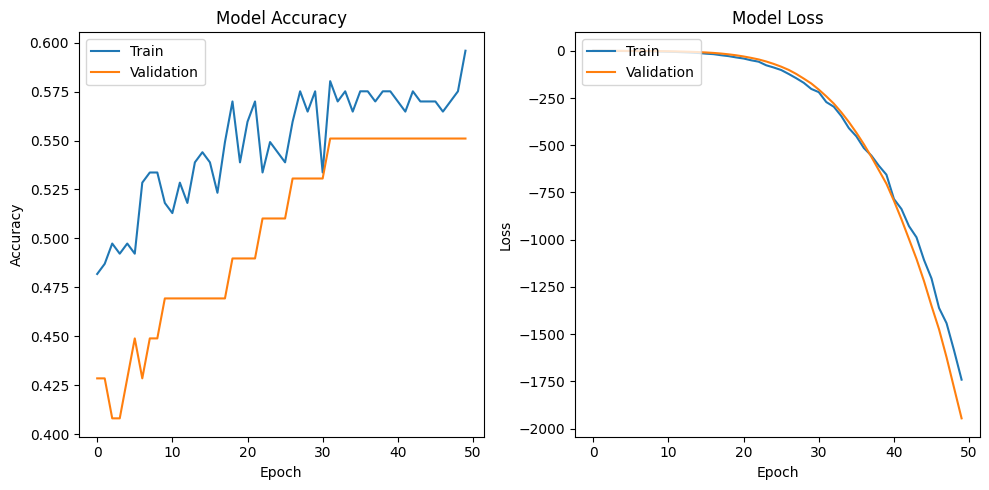

In [16]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(10, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to plot training history
plot_training_history(history)

In [17]:
# Evaluate the model on test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 0s 8ms/step - loss: -1887.2245 - accuracy: 0.5574
Test Accuracy: 0.5573770403862
